# **Upload libraries**

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import skew
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import AdaBoostRegressor

# 1- **Upload the data**

In [2]:
path = 'Funda_dataset_cleaned.csv'
data = pd.read_csv(path)

In [3]:

num_duplicates = data.duplicated().sum()
print("Number of duplicate rows:", num_duplicates)
data.drop_duplicates(inplace=True)
data['Laatste vraagprijs_log'] = np.log1p(data['Laatste vraagprijs'].dropna())


Number of duplicate rows: 13


# Drop time variables

In [4]:
data.drop(['Aangeboden sinds', 'Verkoopdatum'], axis=1, inplace=True)

In [5]:
data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')

<ipython-input-5-855a70a2f4ab>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')


Laatste vraagprijs_log                      0.934878
Woonruimte in m2                            0.680477
Inhoud in m3                                0.587934
Bathrooms                                   0.474886
Vraagprijs per m2                           0.470889
                                              ...   
Schuur/berging_Box                         -0.053630
Isolatie_Geenisolatie                      -0.061635
Voorzieningen_Tvkabel                      -0.077961
Schuur/berging_Vrijstaandestenen berging   -0.094548
Verwarming_Blokverwarming                  -0.136348
Name: Laatste vraagprijs, Length: 104, dtype: float64

In [6]:
cor=data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')

<ipython-input-6-1875e60eb14e>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cor=data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs')


# Drop less than 0.1 correlated

<ipython-input-7-1bfcd880fecc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()
<ipython-input-7-1bfcd880fecc>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  plt.bar(x=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').index), height=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').values), color='teal')
<ipython-input-7-1bfcd880fecc>:12: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to

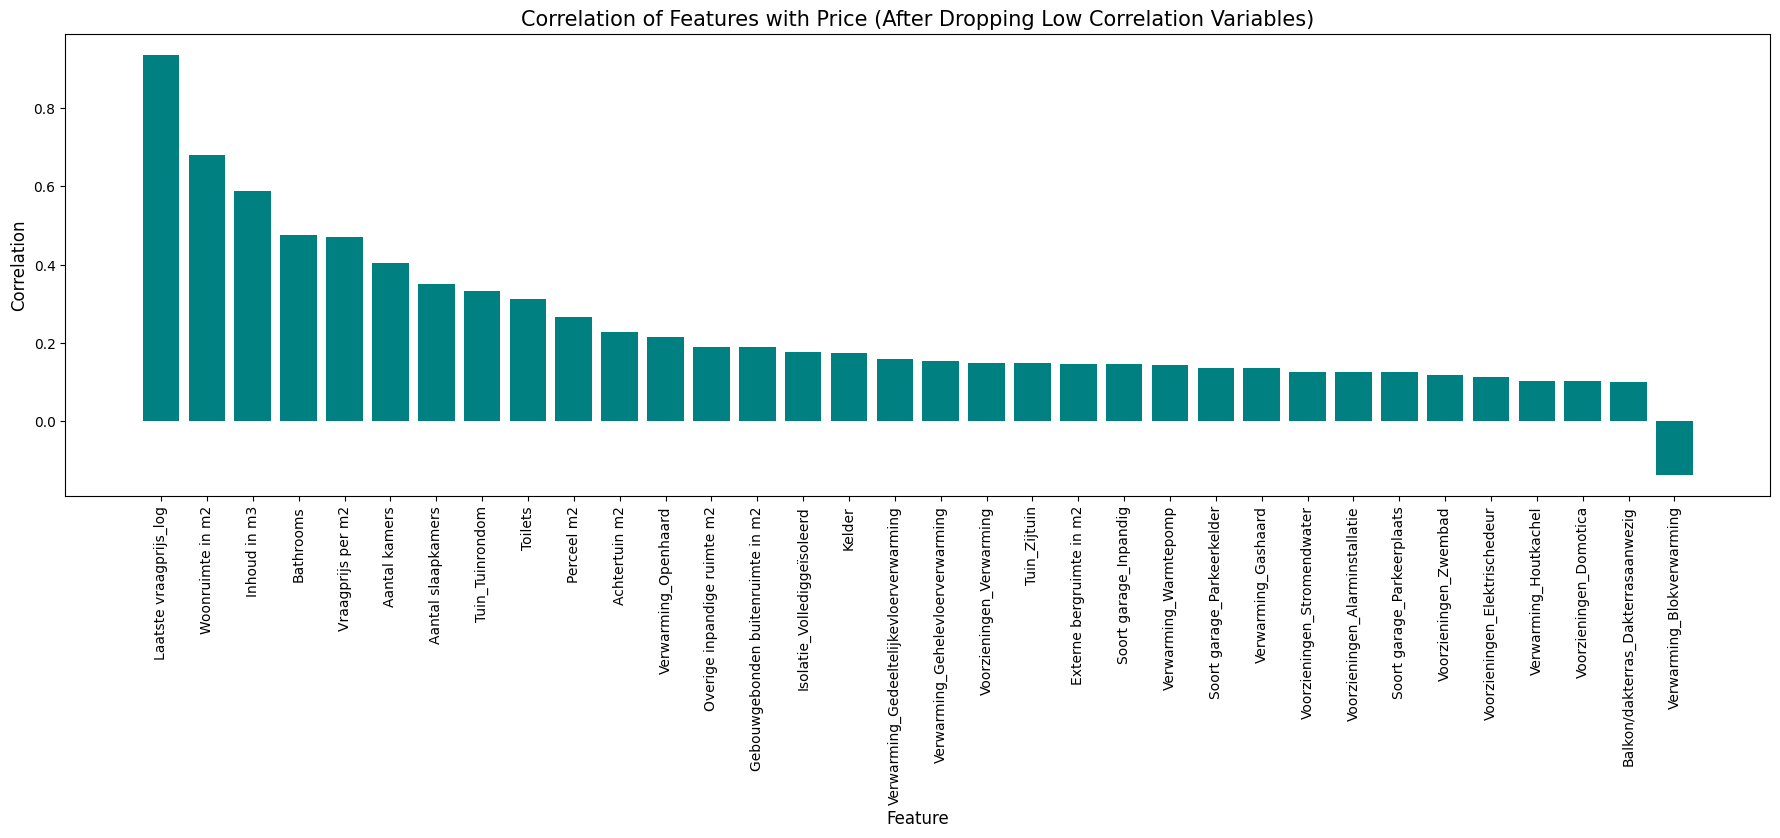

In [7]:
# Calculate the correlation matrix
corr_matrix = data.corr()

# Select the variables that have a correlation less than 0.1 with the target variable
drop_list = corr_matrix[corr_matrix['Laatste vraagprijs'].abs() < 0.1].index.to_list()


data = data.drop(drop_list, axis=1)


plt.figure(figsize=(22,6))
plt.bar(x=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').index), height=list(data.corr()['Laatste vraagprijs'].sort_values(ascending=False).drop('Laatste vraagprijs').values), color='teal')
plt.xticks(rotation=90)
plt.xlabel('Feature', fontsize=12)
plt.ylabel('Correlation', fontsize=12)
plt.title('Correlation of Features with Price (After Dropping Low Correlation Variables)', fontsize=15)
plt.show()

In [8]:
data.shape

(9871, 41)

# **Split the Target variable from the input variables**

In [9]:
X = data.drop('Laatste vraagprijs',axis=1)
y = data['Laatste vraagprijs']

X.head()
X.describe()
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9871 entries, 0 to 9883
Data columns (total 40 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Status                                   9871 non-null   object 
 1   Soort bouw                               9871 non-null   object 
 2   Aantal kamers                            9871 non-null   int64  
 3   Energielabel                             9871 non-null   object 
 4   Overige inpandige ruimte m2              9871 non-null   int64  
 5   Perceel m2                               9871 non-null   int64  
 6   Achtertuin m2                            9871 non-null   int64  
 7   Aantal dagen tot verkoop                 9871 non-null   object 
 8   Vraagprijs per m2                        9871 non-null   int64  
 9   Woonruimte in m2                         9871 non-null   int64  
 10  Gebouwgebonden buitenruimte in m2        9871 no

# **Split the data into Train and Test**

In [10]:
# Split the data into training and testing sets
X_train_full, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# **Transform Categorical variables by recoding**

In [11]:
from sklearn.preprocessing import StandardScaler

# Define transformers
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Select categorical columns with fewer than 1000 unique values
categorical_col = [col for col in X_train_full.columns if X_train_full[col].dtype == 'O' and X_train_full[col].nunique() < 1000]
# Print the selected categorical columns
print("Categorical Columns:")
print(categorical_col)

# Select numerical columns
numerical_col = [col for col in X_train_full.columns if X_train_full[col].dtype in ['float64', 'int64']]
# Print the selected numerical columns
print("Numerical Columns:")
print(numerical_col)

# Combine selected categorical and numerical columns
my_cols = categorical_col + numerical_col
# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_col),
    ('cat', categorical_transformer, categorical_col)])


eval_set_pipe = Pipeline([
    ('preprocessor', preprocessor)
])

Categorical Columns:
['Status', 'Soort bouw', 'Energielabel', 'Aantal dagen tot verkoop', 'Soort dak', 'Soort woonhuis']
Numerical Columns:
['Aantal kamers', 'Overige inpandige ruimte m2', 'Perceel m2', 'Achtertuin m2', 'Vraagprijs per m2', 'Woonruimte in m2', 'Gebouwgebonden buitenruimte in m2', 'Externe bergruimte in m2', 'Inhoud in m3', 'Aantal slaapkamers', 'Bathrooms', 'Toilets', 'Kelder', 'Voorzieningen_Domotica', 'Voorzieningen_Zwembad', 'Voorzieningen_Verwarming', 'Voorzieningen_Stromendwater', 'Voorzieningen_Elektrischedeur', 'Voorzieningen_Alarminstallatie', 'Isolatie_Vollediggeïsoleerd', 'Verwarming_Gedeeltelijkevloerverwarming', 'Verwarming_Warmtepomp', 'Verwarming_Gehelevloerverwarming', 'Verwarming_Blokverwarming', 'Verwarming_Gashaard', 'Verwarming_Openhaard', 'Verwarming_Houtkachel', 'Balkon/dakterras_Dakterrasaanwezig', 'Tuin_Zijtuin', 'Tuin_Tuinrondom', 'Soort garage_Parkeerplaats', 'Soort garage_Inpandig', 'Soort garage_Parkeerkelder', 'Laatste vraagprijs_log']


In [12]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Define transformers
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
])


scaling_type = "robust"

if scaling_type == "standard":
    numerical_transformer.steps.append(('scaler', StandardScaler()))
elif scaling_type == "minmax":
    numerical_transformer.steps.append(('scaler', MinMaxScaler()))
elif scaling_type == "robust":
    numerical_transformer.steps.append(('scaler', RobustScaler()))
else:
    raise ValueError("Invalid scaling type: {}".format(scaling_type))

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Select categorical columns with fewer than 1000 unique values
categorical_col = [col for col in X_train_full.columns if X_train_full[col].dtype == 'O' and X_train_full[col].nunique() < 1000]

print("Categorical Columns:")
print(categorical_col)

# Select numerical columns
numerical_col = [col for col in X_train_full.columns if X_train_full[col].dtype in ['float64', 'int64']]

print("Numerical Columns:")
print(numerical_col)

# Combine selected categorical and numerical columns
my_cols = categorical_col + numerical_col
# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_col),
    ('cat', categorical_transformer, categorical_col)
])


eval_set_pipe = Pipeline([
    ('preprocessor', preprocessor)
])




Categorical Columns:
['Status', 'Soort bouw', 'Energielabel', 'Aantal dagen tot verkoop', 'Soort dak', 'Soort woonhuis']
Numerical Columns:
['Aantal kamers', 'Overige inpandige ruimte m2', 'Perceel m2', 'Achtertuin m2', 'Vraagprijs per m2', 'Woonruimte in m2', 'Gebouwgebonden buitenruimte in m2', 'Externe bergruimte in m2', 'Inhoud in m3', 'Aantal slaapkamers', 'Bathrooms', 'Toilets', 'Kelder', 'Voorzieningen_Domotica', 'Voorzieningen_Zwembad', 'Voorzieningen_Verwarming', 'Voorzieningen_Stromendwater', 'Voorzieningen_Elektrischedeur', 'Voorzieningen_Alarminstallatie', 'Isolatie_Vollediggeïsoleerd', 'Verwarming_Gedeeltelijkevloerverwarming', 'Verwarming_Warmtepomp', 'Verwarming_Gehelevloerverwarming', 'Verwarming_Blokverwarming', 'Verwarming_Gashaard', 'Verwarming_Openhaard', 'Verwarming_Houtkachel', 'Balkon/dakterras_Dakterrasaanwezig', 'Tuin_Zijtuin', 'Tuin_Tuinrondom', 'Soort garage_Parkeerplaats', 'Soort garage_Inpandig', 'Soort garage_Parkeerkelder', 'Laatste vraagprijs_log']


# **Define the eval_set_pipe with the preprocessor**

In [13]:
# Create the preprocessor using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_col),
 ('cat', categorical_transformer, categorical_col)])


eval_set_pipe = Pipeline([
    ('preprocessor', preprocessor)
])

# **Transform X_train and X_test without eval_set_pipe**

In [14]:

# Transform X_train and X_test without eval_set_pipe
X_train_eval = X_train_full[my_cols]
X_test_eval = X_test[my_cols]


# original data to DataFrames with the original index (no transformation)
X_train_eval_df = pd.DataFrame(X_train_eval, index=X_train_full.index)
X_test_eval_df = pd.DataFrame(X_test_eval, index=X_test.index)
X_test_eval_df.head()

,Status,Soort bouw,Energielabel,Aantal dagen tot verkoop,Soort dak,Soort woonhuis,Aantal kamers,Overige inpandige ruimte m2,Perceel m2,Achtertuin m2,...,Verwarming_Gashaard,Verwarming_Openhaard,Verwarming_Houtkachel,Balkon/dakterras_Dakterrasaanwezig,Tuin_Zijtuin,Tuin_Tuinrondom,Soort garage_Parkeerplaats,Soort garage_Inpandig,Soort garage_Parkeerkelder,Laatste vraagprijs_log
6209,Verkocht,Bestaande bouw,B,29 days,Zadeldak bedekt met pannen,"Eengezinswoning, 2-onder-1-kapwoning",5,12,430,200,...,0,0,0,0,0,0,0,0,0,12.818555
343,Verkocht,Nieuwbouw,None,113 days,Plat dak bedekt met bitumineuze dakbedekking,"Herenhuis, 2-onder-1-kapwoning",2,0,48,0,...,0,0,0,0,0,0,0,0,0,13.171155
9788,Verkocht,Bestaande bouw,C,28 days,Plat dak bedekt met bitumineuze dakbedekking,"Eengezinswoning, hoekwoning (hofjeswoning)",6,0,97,0,...,0,0,0,0,0,0,0,0,0,12.948012
3056,Verkocht,Bestaande bouw,B,14 days,Dwarskap bedekt met pannen,"Eengezinswoning, tussenwoning",5,0,122,58,...,0,0,0,0,0,0,0,0,0,12.765691
6513,Verkocht,Bestaande bouw,F,26 days,Plat dak bedekt met bitumineuze dakbedekking,"Eengezinswoning, tussenwoning (hofjeswoning)",3,0,71,0,...,0,0,0,0,0,0,0,0,0,12.367345


# **Transform X_train and X_test using eval_set_pipe**

In [15]:
# Create a DataFrame with column names
column_names_df = pd.DataFrame([X_train_full[my_cols].columns])

# Transform X_train and X_test using eval_set_pipe
X_train_eval = eval_set_pipe.fit_transform(X_train_full[my_cols])
X_test_eval = eval_set_pipe.transform(X_test[my_cols])

# Convert the transformed data to DataFrames with the original index
X_train_eval_df = pd.DataFrame(X_train_eval, index=X_train_full.index)
X_test_eval_df = pd.DataFrame(X_test_eval, index=X_test.index)


# **Random Forest Paramaeters**

In [ ]:
#Best Parameters: {'max_depth': 60, 'max_features': 'auto', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 1942}

# **Random Forest  after geting parameters from Tuning**

In [ ]:
# Use the best parameters obtained from the randomized search
best_model_rf = RandomForestRegressor(
    n_estimators=1942,
    max_features='auto',
    min_samples_leaf=3,
    min_samples_split=6,
    max_depth=60,
    random_state=60
)


y_train_numeric = y_train.astype('float')

# Train Rf model with the best parameters
best_model_rf.fit(X_train_eval, y_train_numeric)

#  test set
y_test_pred_rf = best_model_rf.predict(X_test_eval)

best_model_params_df = pd.DataFrame([best_model_rf.get_params()])
print("Best Model Parameters:")
print(best_model_params_df)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


Best Model Parameters:
   bootstrap  ccp_alpha      criterion  max_depth max_features max_leaf_nodes  \
0       True        0.0  squared_error         60         auto           None   

  max_samples  min_impurity_decrease  min_samples_leaf  min_samples_split  \
0        None                    0.0                 3                  6   

   min_weight_fraction_leaf  n_estimators n_jobs  oob_score  random_state  \
0                       0.0          1942   None      False            60   

   verbose  warm_start  
0        0       False  


# **Using HyperParameters to find the Best Random Forest Model**

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint


y_train_numeric = y_train.astype('float')
param_dist = {
    'n_estimators': randint(100, 2000),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'min_samples_split': randint(2, 11),
    'min_samples_leaf': randint(1, 11),
}

# Create a RandomForestRegressor model
base_model_rf = RandomForestRegressor(random_state=60)

# Create a RandomizedSearchCV object
random_search_rf = RandomizedSearchCV(base_model_rf, param_distributions=param_dist, n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)

# Fit the RandomizedSearchCV object to the training data
random_search_rf.fit(X_train_eval, y_train_numeric)

# Get the best parameters from the RandomizedSearchCV
best_params_rf = random_search_rf.best_params_

# Print the best parameters
print("Best Parameters:", best_params_rf)

# Get the best model from the RandomizedSearchCV object
best_model_rf = random_search_rf.best_estimator_

# Make predictions on the test set with the best model
y_test_pred_rf = best_model_rf.predict(X_test_eval)


# **Calculate various accuracy measures**

In [ ]:
# Calculate various accuracy measures
mse = mean_squared_error(y_test, y_test_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred_rf)

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - y_test_pred_rf) / y_test)) * 100

from sklearn import metrics
print('R2 Score_Random Forest Regression=',metrics.r2_score(y_test, y_test_pred_rf))

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("Mean Absolute Error (MAE):", mae)
print("Mean Absolute Percentage Error (MAPE):", mape, "%")


R2 Score_Random Forest Regression= 0.9924949524115806
Mean Squared Error (MSE): 325066750.3013682
Root Mean Squared Error (RMSE): 18029.607602534456
Mean Absolute Error (MAE): 4029.0419609965384
Mean Absolute Percentage Error (MAPE): 0.7774681911503302 %


# **1- Feature Importance Analysis**

In [ ]:
import plotly.graph_objects as go

feat_importances = best_model_rf.feature_importances_[:39]
indices = np.argsort(feat_importances)

# Create a bar plot using plotly
fig = go.Figure()

fig.add_trace(
    go.Bar(
        x=feat_importances[indices],
        y=X_train_full[my_cols].columns,
        orientation='h',
        marker=dict(
            color=feat_importances[indices],
            colorscale='Viridis',  
            cmin=min(feat_importances),
            cmax=max(feat_importances),
            colorbar=dict(title='Feature Importance'),
        ),
        text=feat_importances[indices],  
        hoverinfo='text+x+y',  
    )
)

fig.update_layout(
    title="Feature Importances - Random Forest Regressor",
    xaxis_title='Feature Importance',
    yaxis_title='Feature Name',
    height=600,
    width=1400,
)

fig.show()


<ipython-input-20-c588da589610>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test, label="Actual Value", color="r", shade=True)
<ipython-input-20-c588da589610>:10: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(y_test_pred_rf, label="Predicted Values", color="b", shade=True)


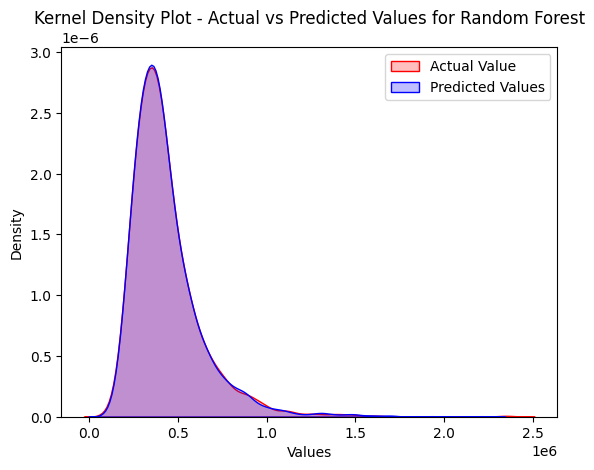

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming y_test and y_test_pred_tabnet are actual and predicted values
# y_test = np.array(y_test).flatten()  # Ensure 1-dimensional
# y_test_pred_rf = np.array(y_test_pred_rf).flatten()  # Ensure 1-dimensional

# # Create a kernel density plot
# sns.kdeplot(y_test, label="Actual Value", color="r", shade=True)
# sns.kdeplot(y_test_pred_rf, label="Predicted Values", color="b", shade=True)

# # Set plot labels and title
# plt.title('Kernel Density Plot - Actual vs Predicted Values for Random Forest')
# plt.xlabel('Values')
# plt.ylabel('Density')

# # Show the legend
# plt.legend()

# # Show the plot
# plt.show()


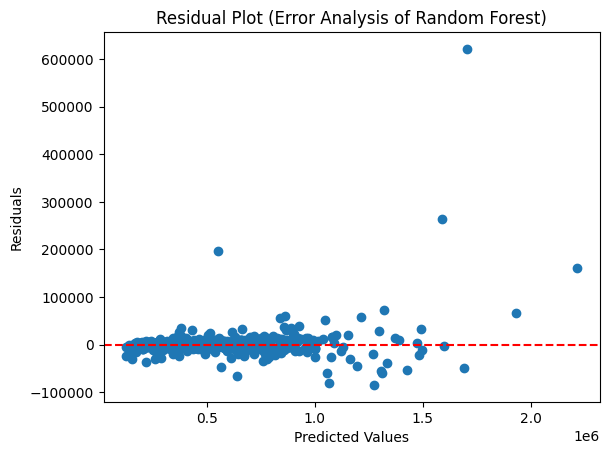

In [ ]:
residuals = y_test - y_test_pred_rf
plt.scatter(y_test_pred_rf, residuals)
plt.title('Residual Plot (Error Analysis of Random Forest)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

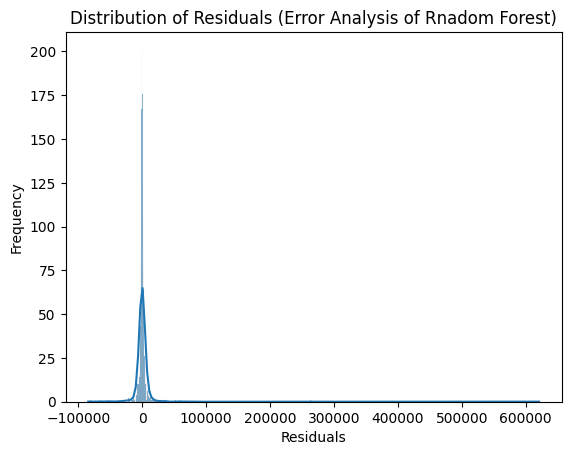

In [ ]:
import seaborn as sns
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals (Error Analysis of Rnadom Forest)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

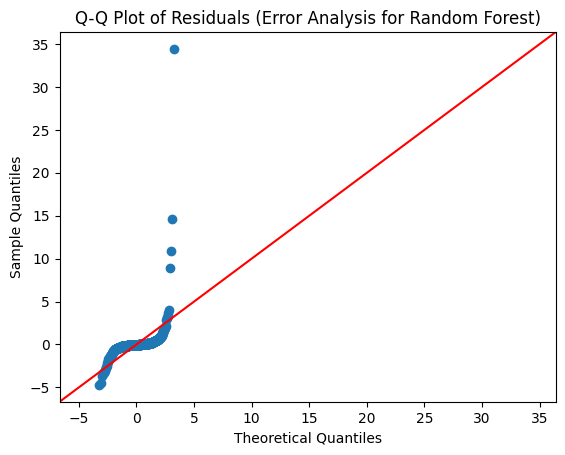

In [ ]:
import statsmodels.api as sm

residuals_standardized = (residuals - np.mean(residuals)) / np.std(residuals)

sm.qqplot(residuals_standardized, line='45', fit=True)
plt.title('Q-Q Plot of Residuals (Error Analysis for Random Forest)')
plt.show()
